In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
# import dask
# import dask.dataframe as dd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import scipy

In [2]:
def well_idx_to_well_id(idx):
    """
    Convert an well index in a 96-well plate (8x12) to [char][int] ID.
    0 -> A01
    ...
    95 -> H12
    """
    assert idx >= 0 and idx < (12 * 8), "Index not in 96-well plate"
    # a-h
    chars = [chr(ord('A') + x) for x in range(ord('H') - ord('A') + 1)]
    row, col = divmod(idx, 12)
    return f"{chars[row]}{(col + 1):02d}"

In [3]:
DATA_DIR = os.path.expanduser("~/sd2e-projects/sd2e-project-14/xplan-reactor/data/transcriptic")
assert os.path.isdir(DATA_DIR)
df = pd.read_csv(os.path.join(DATA_DIR, 'r1c5va879uaex_r1c639xp952g4.csv'), index_col=0)
df

/home/jupyter/tacc-work/jupyter_packages/envs/xplan-experiment-analysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/jupyter/tacc-work/jupyter_packages/envs/xplan-experiment-analysis/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,inc_temp,inc_time_1,inc_time_2,plan,lab,growth_media_1,growth_media_2,od_cutoff,source_container,lab_id,...,SSC_H,BL1_H,RL1_H,FSC_W,SSC_W,BL1_W,RL1_W,index,live_no_stain,live
0,warm_30,16:hour,16:hour,11_8_2018_1,transcriptic,standard_media,standard_media,0.1,ct1bvwm8bbtq9e,r1c5va879uaex_r1c639xp952g4,...,760446.0,695.0,6353.0,1023.0,1023.0,0.0,0.0,0,0,0.0
1,warm_30,16:hour,16:hour,11_8_2018_1,transcriptic,standard_media,standard_media,0.1,ct1bvwm8bbtq9e,r1c5va879uaex_r1c639xp952g4,...,52136.0,103.0,67.0,20.0,33.0,0.0,0.0,1,1,1.0
2,warm_30,16:hour,16:hour,11_8_2018_1,transcriptic,standard_media,standard_media,0.1,ct1bvwm8bbtq9e,r1c5va879uaex_r1c639xp952g4,...,263206.0,267.0,86.0,35.0,86.0,0.0,0.0,2,1,1.0
3,warm_30,16:hour,16:hour,11_8_2018_1,transcriptic,standard_media,standard_media,0.1,ct1bvwm8bbtq9e,r1c5va879uaex_r1c639xp952g4,...,258952.0,457.0,95.0,32.0,81.0,0.0,0.0,3,1,0.0
4,warm_30,16:hour,16:hour,11_8_2018_1,transcriptic,standard_media,standard_media,0.1,ct1bvwm8bbtq9e,r1c5va879uaex_r1c639xp952g4,...,69802.0,66.0,58.0,20.0,35.0,0.0,0.0,4,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2702149,warm_30,16:hour,16:hour,11_8_2018_1,transcriptic,standard_media,standard_media,0.1,ct1bvwm8bbtq9e,r1c5va879uaex_r1c639xp952g4,...,238988.0,706.0,96.0,42.0,95.0,0.0,0.0,2702149,1,NaN
2702150,warm_30,16:hour,16:hour,11_8_2018_1,transcriptic,standard_media,standard_media,0.1,ct1bvwm8bbtq9e,r1c5va879uaex_r1c639xp952g4,...,212047.0,569.0,98.0,42.0,90.0,0.0,0.0,2702150,1,NaN
2702151,warm_30,16:hour,16:hour,11_8_2018_1,transcriptic,standard_media,standard_media,0.1,ct1bvwm8bbtq9e,r1c5va879uaex_r1c639xp952g4,...,399107.0,1220.0,153.0,62.0,137.0,0.0,0.0,2702151,1,NaN
2702152,warm_30,16:hour,16:hour,11_8_2018_1,transcriptic,standard_media,standard_media,0.1,ct1bvwm8bbtq9e,r1c5va879uaex_r1c639xp952g4,...,254195.0,613.0,101.0,39.0,89.0,0.0,0.0,2702152,1,NaN


In [4]:
df.columns

Index(['inc_temp', 'inc_time_1', 'inc_time_2', 'plan', 'lab', 'growth_media_1',
       'growth_media_2', 'od_cutoff', 'source_container', 'lab_id', 'id',
       'strain_name', 'gate', 'input', 'od', 'filename', 'replicate', 'output',
       'media', 'plate_id', 'Time', 'FSC_A', 'SSC_A', 'BL1_A', 'RL1_A',
       'FSC_H', 'SSC_H', 'BL1_H', 'RL1_H', 'FSC_W', 'SSC_W', 'BL1_W', 'RL1_W',
       'index', 'live_no_stain', 'live'],
      dtype='object')

In [5]:
df['growth_media'] = df['growth_media_1']
df = df.drop(columns=['growth_media_1', 'growth_media_2'])

In [6]:
df['inc_time'] = df['inc_time_1']
df.drop(columns=['inc_time_1', 'inc_time_2'], inplace=True)

In [7]:
df['strain_name'].unique()

array(['https://hub.sd2e.org/user/sd2e/design/UWBF_7299/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_8544/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_7375/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_6390/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_8545/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_6388/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_8231/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_6389/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_6391/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_7377/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_7300/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_8542/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_16967/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_16970/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_7373/1',
       'https://hub.sd2e.org/user/sd2e/design/UWBF_7376/1',
       'https://hub.sd2e.org/user/sd2e

In [8]:
df.query('gate == "NOR" and input == 11')['source_container'].unique()

array(['ct1bvwm8bbtq9e'], dtype=object)

In [9]:
df.query('gate == "NOR" and input == 11').iloc[0]

inc_temp                                                      warm_30
plan                                                      11_8_2018_1
lab                                                      transcriptic
od_cutoff                                                         0.1
source_container                                       ct1bvwm8bbtq9e
lab_id                                    r1c5va879uaex_r1c639xp952g4
id                                                   11_8_2018_1_0_D2
strain_name         https://hub.sd2e.org/user/sd2e/design/UWBF_6391/1
gate                                                              NOR
input                                                            11.0
od                                                            0.00075
filename            /work/05202/dbryce/xplan-reactor/fcs/YeastGate...
replicate                                                           0
output                                                            0.0
media               

In [10]:
id_re = re.compile('.*_([A-Z])([1-9][0-9]*)$')

In [11]:
def no_well_finder(x):
    return re.match(id_re, x) is None

In [12]:
def find_well(x):
    assert isinstance(x, str), f"Trying to find well in non-string value {x}"
    match = re.match(id_re, x)
    if match is None:
        raise ValueError(f"Couldn't find well ID in {x}")
    row = match.group(1)
    col = int(match.group(2))
    return f"{row}{col:02d}"

find_wellv = np.vectorize(find_well)

In [13]:
wells = find_wellv(df['id'])

In [14]:
wells[0]

'A01'

In [15]:
df['well'] = wells

In [16]:
df.query('gate == "NOR" and input == 11')['well'].unique()

array(['D02', 'F03', 'B07', 'D07', 'C08', 'A09'], dtype=object)

In [17]:
nor_11 = df.query('gate == "NOR" and input == 11')
nor_11.at[:, 'logGFP'] = np.log10(np.maximum(nor_11['BL1_A'], 1))

/home/jupyter/tacc-work/jupyter_packages/envs/xplan-experiment-analysis/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/jupyter/tacc-work/jupyter_packages/envs/xplan-experiment-analysis/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [18]:
nor_11[['BL1_A', 'logGFP']].describe()

,BL1_A,logGFP
count,1.800000e+05,180000.000000
mean,1.678201e+03,3.077335
std,6.227588e+03,0.395568
min,-1.780000e+02,0.000000
25%,7.730000e+02,2.888179
50%,1.192000e+03,3.076276
75%,1.948000e+03,3.289589
max,1.048575e+06,6.020599


The following shows that the NOR 11 outputs are *unimodal* on this plate, confirming our expectation that the individual replicates are unimodal, but across replicates there is bimodality, and perhaps two different sub-populations.

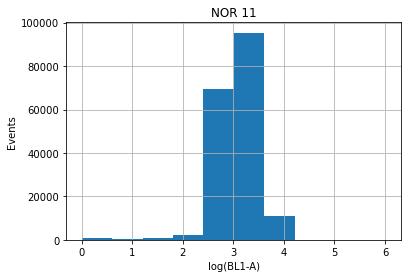

In [19]:
ax = nor_11.hist(column='logGFP').flatten()[0]
ax.set_title("NOR 11")
ax.set_ylabel("Events")
ax.set_xlabel("log(BL1-A)");

# Container data

In [66]:
nor_11.source_container.unique()

array(['ct1bvwm8bbtq9e'], dtype=object)

In [20]:
low_container = pd.read_csv('container_results_low.csv')
low_container.head()

,aliquot_name,container_label,container_id,container_type,aliquot_id,well,created_at,volume_remaining
0,UW BIOFAB YEAST 119677,YeastGatesStockPlate-08-30-2018-1_35,ct1bvwm8berzd4,96-pcr,aq1bvxfyvc7zqk,29,Thu Aug 30 2018 18:30:24 GMT-0500,30.0
1,UW BIOFAB YEAST 119676,YeastGatesStockPlate-08-30-2018-1_35,ct1bvwm8berzd4,96-pcr,aq1bvxfyvb4wpk,8,Thu Aug 30 2018 18:30:24 GMT-0500,30.0
2,UW BIOFAB YEAST 119679,YeastGatesStockPlate-08-30-2018-1_35,ct1bvwm8berzd4,96-pcr,aq1bvxfyvfym3z,88,Thu Aug 30 2018 18:30:24 GMT-0500,30.0
3,UW BIOFAB YEAST 119670,YeastGatesStockPlate-08-30-2018-1_35,ct1bvwm8berzd4,96-pcr,aq1bvxfyvd8wjh,48,Thu Aug 30 2018 18:30:24 GMT-0500,30.0
4,UW BIOFAB YEAST 119671,YeastGatesStockPlate-08-30-2018-1_35,ct1bvwm8berzd4,96-pcr,aq1bvxfyve8qae,62,Thu Aug 30 2018 18:30:24 GMT-0500,30.0


In [21]:
high_container = pd.read_csv('container_results_high.csv')
high_container.head()

,aliquot_name,container_label,container_id,container_type,aliquot_id,well,created_at,volume_remaining
0,none,YeastGatesStockPlate-08-30-2018-1_12,ct1bvwm8bbtq9e,96-pcr,aq1bvxbuwngqdm,11,Thu Aug 30 2018 17:32:38 GMT-0500,30.0
1,UW BIOFAB YEAST 119692,YeastGatesStockPlate-08-30-2018-1_12,ct1bvwm8bbtq9e,96-pcr,aq1bvxbuwnhtgn,12,Thu Aug 30 2018 17:32:38 GMT-0500,30.0
2,UW BIOFAB YEAST 119679,YeastGatesStockPlate-08-30-2018-1_12,ct1bvwm8bbtq9e,96-pcr,aq1bvxbuwn8zqc,5,Thu Aug 30 2018 17:32:38 GMT-0500,30.0
3,none,YeastGatesStockPlate-08-30-2018-1_12,ct1bvwm8bbtq9e,96-pcr,aq1bvxbuwqjh3f,58,Thu Aug 30 2018 17:32:38 GMT-0500,30.0
4,UW BIOFAB YEAST 119676,YeastGatesStockPlate-08-30-2018-1_12,ct1bvwm8bbtq9e,96-pcr,aq1bvxbuwnde4g,8,Thu Aug 30 2018 17:32:38 GMT-0500,30.0


The high container is the one that is relevant.

In [22]:
low_container.rename(columns={'well': 'well_idx'}, inplace=True)
high_container.rename(columns={'well': 'well_idx'}, inplace=True)

In [23]:
low_container.at[:, 'well'] = np.vectorize(well_idx_to_well_id)(low_container['well_idx'])

In [24]:
high_container.at[:, 'well'] = np.vectorize(well_idx_to_well_id)(high_container['well_idx'])

In [25]:
high_container.well.unique()

array(['A12', 'B01', 'A06', 'E11', 'A09', 'A10', 'B06', 'A01', 'A05',
       'H10', 'F07', 'E03', 'C01', 'C02', 'A02', 'E12', 'C10', 'G11',
       'B07', 'D07', 'C11', 'F08', 'C03', 'A04', 'F01', 'E04', 'B11',
       'C05', 'H08', 'F10', 'F11', 'H06', 'H07', 'B04', 'C08', 'E08',
       'C07', 'A07', 'D03', 'D04', 'B03', 'B12', 'H11', 'H12', 'G07',
       'G08', 'E09', 'H02', 'D12', 'F04', 'G10', 'G05', 'E05', 'G06',
       'E06', 'G09', 'A08', 'H03', 'H04', 'F05', 'H05', 'F06', 'D05',
       'D06', 'G01', 'G02', 'E01', 'E02', 'B05', 'E10', 'C09', 'F12',
       'G12', 'B10', 'C06', 'H01', 'F02', 'F03', 'B02', 'G03', 'H09',
       'E07', 'A11', 'D11', 'B08', 'A03', 'G04', 'C12', 'D01', 'F09',
       'D08', 'D09', 'D10', 'C04', 'B09', 'D02'], dtype=object)

In [26]:
nor_11.well.unique()

array(['D02', 'F03', 'B07', 'D07', 'C08', 'A09'], dtype=object)

In [69]:
nor_11_well_info = nor_11.set_index(['well']).join(high_container[['well', 'aliquot_name']].set_index(['well'])).groupby('well').agg('first')

In [70]:
nor_11_well_info[['aliquot_name', 'strain_name', 'gate', 'input']]

,aliquot_name,strain_name,gate,input
well,,,,
A09,UW BIOFAB YEAST 119676,https://hub.sd2e.org/user/sd2e/design/UWBF_6391/1,NOR,11.0
B07,UW BIOFAB Yeast W303 diploid 16970,https://hub.sd2e.org/user/sd2e/design/UWBF_6391/1,NOR,11.0
C08,UW BIOFAB Yeast W303 diploid 16967,https://hub.sd2e.org/user/sd2e/design/UWBF_6391/1,NOR,11.0
D02,UW BIOFAB YEAST 119695,https://hub.sd2e.org/user/sd2e/design/UWBF_6391/1,NOR,11.0
D07,UW BIOFAB Yeast W303 diploid 16969,https://hub.sd2e.org/user/sd2e/design/UWBF_6391/1,NOR,11.0
F03,UW BIOFAB YEAST 119671,https://hub.sd2e.org/user/sd2e/design/UWBF_6391/1,NOR,11.0


# Old stuff ...

In [27]:
nor_11.loc[:, 'log(FSC_H)'] = np.log10(np.maximum(nor_11['FSC_H'], 1))

/home/jupyter/tacc-work/jupyter_packages/envs/xplan-experiment-analysis/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/jupyter/tacc-work/jupyter_packages/envs/xplan-experiment-analysis/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


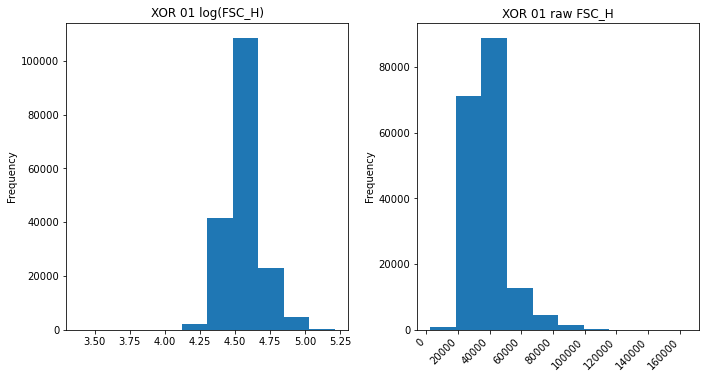

In [28]:
fig, axeses = plt.subplots(1, 2)
fig.tight_layout()
fig.set_size_inches(10, 5)
nor_11['log(FSC_H)'].plot(kind='hist', ax=axeses[0], title='XOR 01 log(FSC_H)')
nor_11['FSC_H'].plot(kind='hist', ax=axeses[1], title='XOR 01 raw FSC_H')
plt.setp(axeses[1].get_xticklabels(), ha="right", rotation=45);

In [29]:
nor_11[['log(FSC_H)','FSC_H']].describe()


,log(FSC_H),FSC_H
count,180000.000000,180000.000000
mean,4.563878,38229.228094
std,0.124114,12052.542028
min,3.388456,2446.000000
25%,4.487746,30743.000000
50%,4.566048,36817.000000
75%,4.625683,42236.000000
max,5.214510,163874.000000


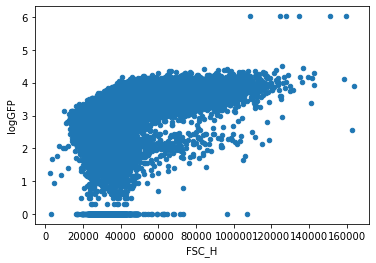

In [30]:
ax = nor_11.plot(kind='scatter', x='FSC_H', y='logGFP')


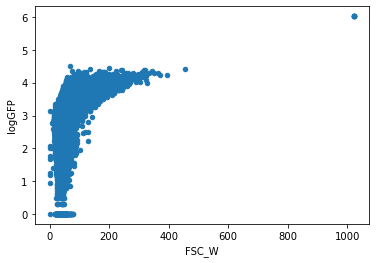

In [31]:
ax = nor_11.plot(kind='scatter', x='FSC_W', y='logGFP')


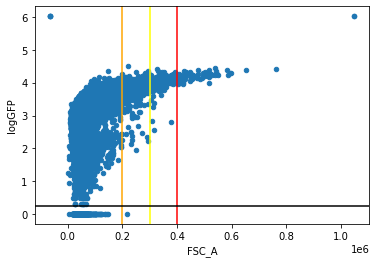

In [32]:
ax = nor_11.plot(kind='scatter', x='FSC_A', y='logGFP')
ax.axvline(400000, color='red')
ax.axvline(200000, color='orange')
ax.axvline(300000, color='yellow');
ax.axhline(0.25, color='black');

In [33]:
nor_11.columns

Index(['inc_temp', 'plan', 'lab', 'od_cutoff', 'source_container', 'lab_id',
       'id', 'strain_name', 'gate', 'input', 'od', 'filename', 'replicate',
       'output', 'media', 'plate_id', 'Time', 'FSC_A', 'SSC_A', 'BL1_A',
       'RL1_A', 'FSC_H', 'SSC_H', 'BL1_H', 'RL1_H', 'FSC_W', 'SSC_W', 'BL1_W',
       'RL1_W', 'index', 'live_no_stain', 'live', 'growth_media', 'inc_time',
       'well', 'logGFP', 'log(FSC_H)'],
      dtype='object')

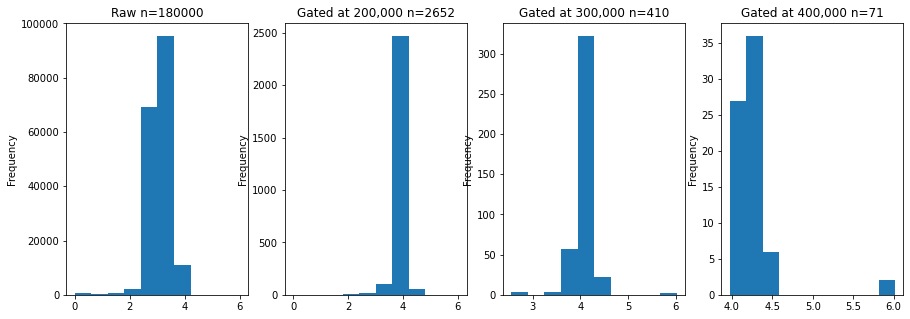

In [34]:
fig, axeses = plt.subplots(1, 4)
fig.set_size_inches(15, 5)
gated = nor_11[nor_11['FSC_A'] > 400000]
gated200k = nor_11[nor_11['FSC_A'] > 200000]
gated300k = nor_11[nor_11['FSC_A'] > 300000]


nor_11['logGFP'].plot(kind='hist', ax=axeses[0], title=f'Raw n={nor_11.shape[0]}')
gated200k['logGFP'].plot(kind='hist', ax=axeses[1], title=f'Gated at 200,000 n={gated200k.shape[0]}');
gated300k['logGFP'].plot(kind='hist', ax=axeses[2], title=f'Gated at 300,000 n={gated300k.shape[0]}');
gated['logGFP'].plot(kind='hist', ax=axeses[3], title=f'Gated at 400,000 n={gated.shape[0]}');


In [35]:
len(nor_11['id'].unique())

6

(0.0, 100000.0)

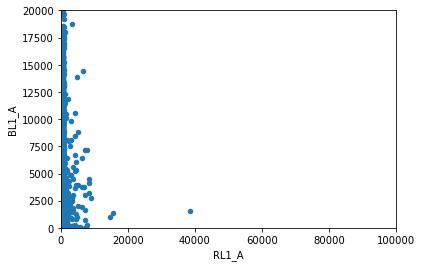

In [36]:
ax = nor_11.plot(kind='scatter', x='RL1_A', y='BL1_A')
ax.set_ylim(0, 20000); ax.set_xlim(0, 100000)

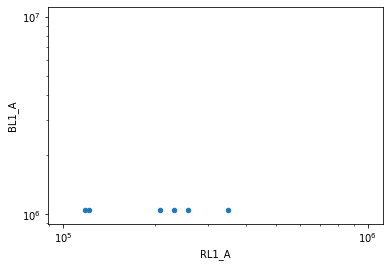

In [37]:
ax = nor_11.plot(kind='scatter', x='RL1_A', y='BL1_A')
plt.xscale("log") ; plt.yscale("log")

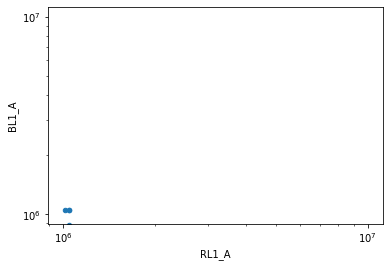

In [38]:
ax = df.plot(kind='scatter', x='RL1_A', y='BL1_A')
plt.xscale("log") ; plt.yscale("log")

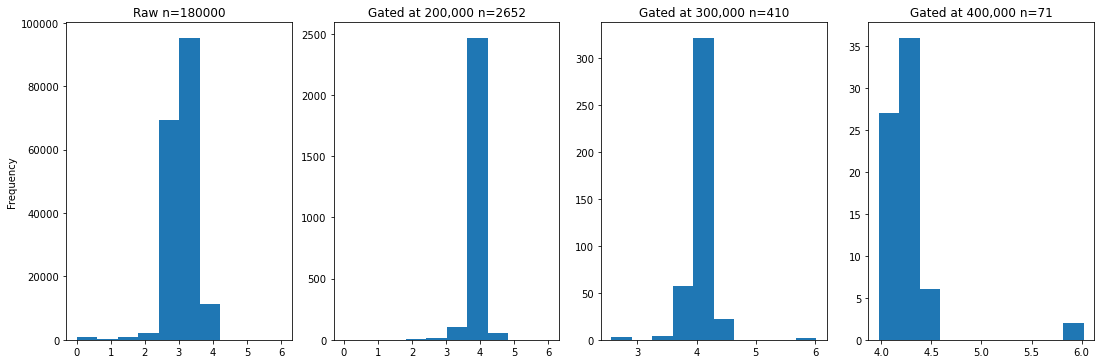

In [39]:
fig, axeses = plt.subplots(1, 4)
fig.set_size_inches(15, 5)
gated = nor_11[nor_11['FSC_A'] > 400000]
gated200k = nor_11[nor_11['FSC_A'] > 200000]
gated300k = nor_11[nor_11['FSC_A'] > 300000]
fig.tight_layout()

nor_11['logGFP'].plot(kind='hist', ax=axeses[0], title=f'Raw n={nor_11.shape[0]}')
gated200k['logGFP'].plot(kind='hist', ax=axeses[1], title=f'Gated at 200,000 n={gated200k.shape[0]}');
axeses[1].set_ylabel(None)
gated300k['logGFP'].plot(kind='hist', ax=axeses[2], title=f'Gated at 300,000 n={gated300k.shape[0]}');
axeses[2].set_ylabel(None)
gated['logGFP'].plot(kind='hist', ax=axeses[3], title=f'Gated at 400,000 n={gated.shape[0]}');
axeses[3].set_ylabel(None);


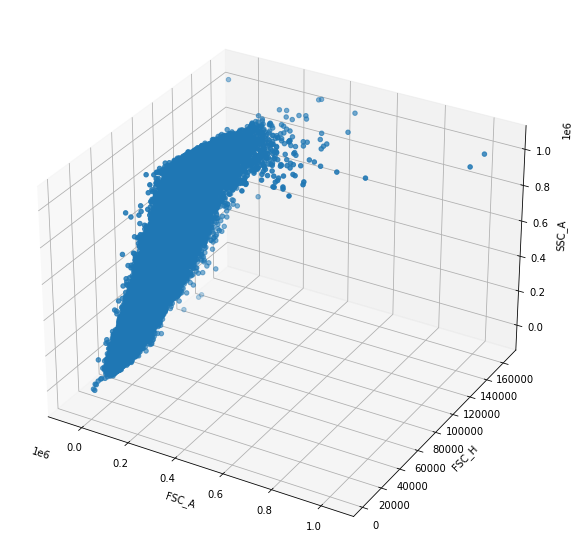

In [40]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=nor_11['FSC_A'], ys=nor_11['FSC_H'], zs=nor_11['SSC_A'])
ax.set_xlabel('FSC_A')
ax.set_ylabel('FSC_H')
ax.set_zlabel('SSC_A');

# Forward scatter channels

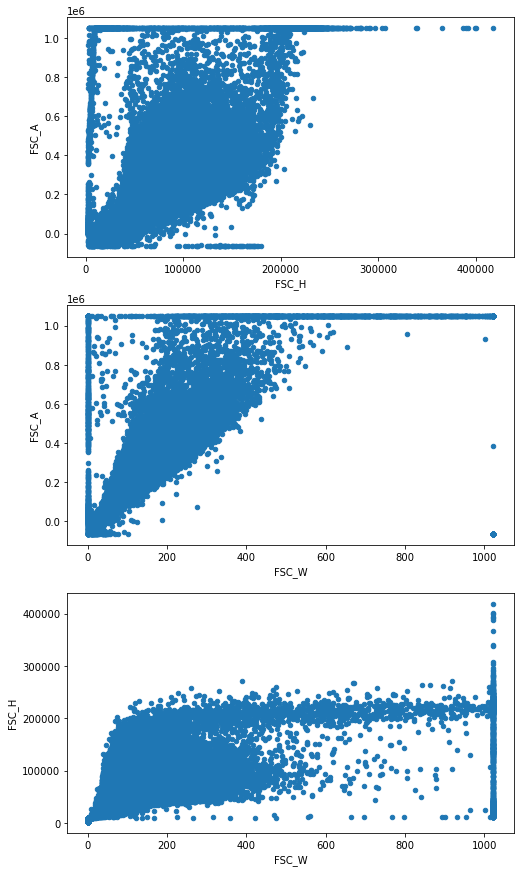

In [41]:
fig, axeses = plt.subplots(3, 1)
fig.set_size_inches(8, 15)
df.plot(kind='scatter', x= 'FSC_H', y='FSC_A', ax=axeses[0])
df.plot(kind='scatter', x= 'FSC_W', y='FSC_A', ax=axeses[1])
df.plot(kind='scatter', x= 'FSC_W', y='FSC_H', ax=axeses[2]);

<AxesSubplot:xlabel='FSC_W', ylabel='FSC_H'>

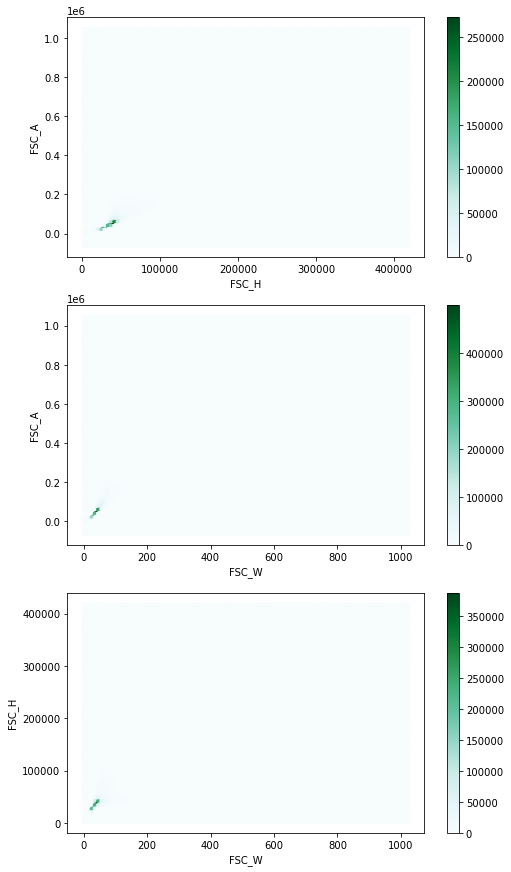

In [42]:
fig, axeses = plt.subplots(3, 1)
fig.set_size_inches(8, 15)
df.plot.hexbin(x= 'FSC_H', y='FSC_A', ax=axeses[0])
df.plot.hexbin(x= 'FSC_W', y='FSC_A', ax=axeses[1])
df.plot.hexbin(x= 'FSC_W', y='FSC_H', ax=axeses[2])

In [43]:

model = LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(df['FSC_A'].to_numpy(), df['FSC_H'].to_numpy(), test_size=0.7, random_state=0)
print(X_train.shape, Y_train.shape)

(810646,) (810646,)


In [44]:
model.fit(X_train.reshape((-1, 1)), Y_train)

LinearRegression()

In [45]:
model.score(X_train.reshape((-1, 1)), Y_train)

0.6345177774904548

In [46]:
model = LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(df['FSC_A'].to_numpy(), df['FSC_W'].to_numpy(), test_size=0.7, random_state=0)
model.fit(X_train.reshape((-1, 1)), Y_train)
model.score(X_train.reshape((-1, 1)), Y_train)

0.8041648273601304

# Side-scatter channels

<AxesSubplot:xlabel='SSC_W', ylabel='SSC_H'>

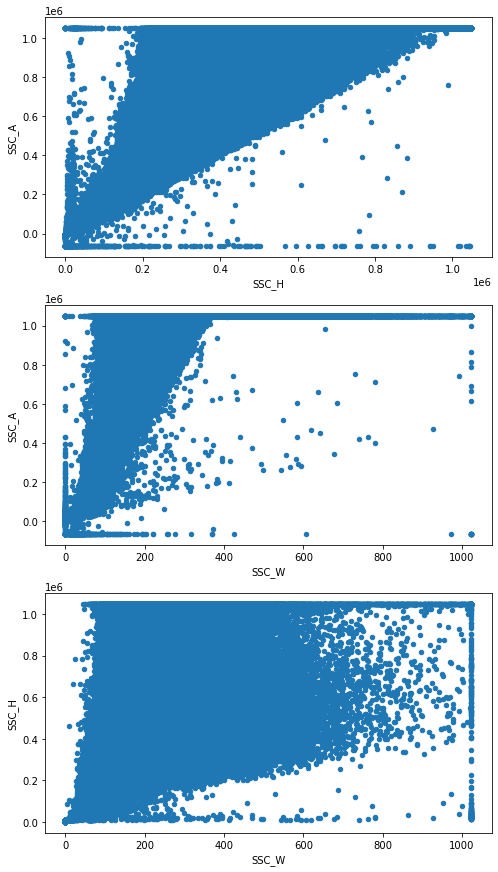

In [47]:
fig, axeses = plt.subplots(3, 1)
fig.set_size_inches(8, 15)
df.plot(kind='scatter', x= 'SSC_H', y='SSC_A', ax=axeses[0])
df.plot(kind='scatter', x= 'SSC_W', y='SSC_A', ax=axeses[1])
df.plot(kind='scatter', x= 'SSC_W', y='SSC_H', ax=axeses[2])

<AxesSubplot:xlabel='SSC_W', ylabel='SSC_H'>

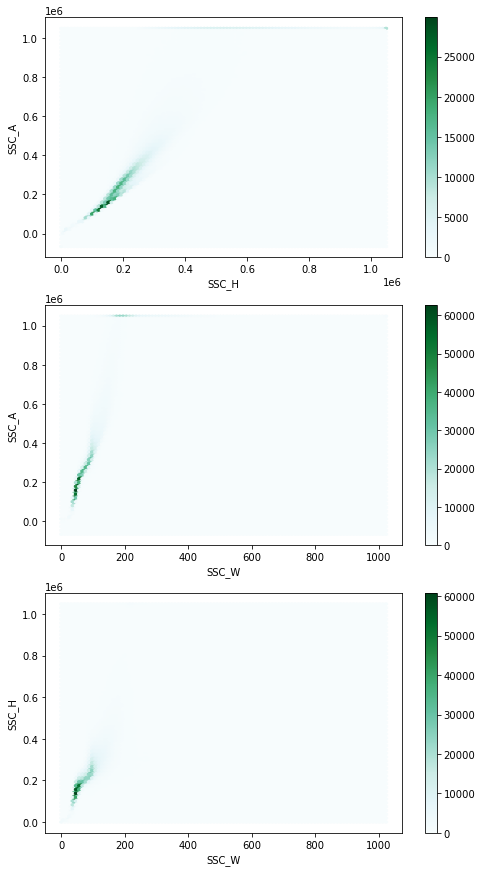

In [48]:
fig, axeses = plt.subplots(3, 1)
fig.set_size_inches(8, 15)
df.plot(kind='hexbin', x= 'SSC_H', y='SSC_A', ax=axeses[0])
df.plot(kind='hexbin', x= 'SSC_W', y='SSC_A', ax=axeses[1])
df.plot(kind='hexbin', x= 'SSC_W', y='SSC_H', ax=axeses[2])

In [49]:
model = LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(df['SSC_A'].to_numpy(), df['SSC_H'].to_numpy(), test_size=0.7, random_state=0)
model.fit(X_train.reshape((-1, 1)), Y_train)
print(f"Score on training data is {model.score(X_train.reshape((-1, 1)), Y_train):.2f}")
print(f"Score on test data is {model.score(X_test.reshape((-1, 1)), Y_test):.2f}")

Score on training data is 0.76
Score on test data is 0.76


In [50]:
model = LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(df['SSC_A'].to_numpy(), df['SSC_W'].to_numpy(), test_size=0.7, random_state=0)
model.fit(X_train.reshape((-1, 1)), Y_train)
model.score(X_train.reshape((-1, 1)), Y_train)

0.7195046950029824

In [51]:
model = LinearRegression()
X_train, X_test, Y_train, Y_test = train_test_split(df['SSC_H'].to_numpy(), df['SSC_W'].to_numpy(), test_size=0.7, random_state=0)
model.fit(X_train.reshape((-1, 1)), Y_train)
model.score(X_train.reshape((-1, 1)), Y_train)

0.5000389244918808

From the above, it looks like the `SSC_A` channel has the most information of the three.

# Combination of FSC and SSC

In [52]:
fig.set_size_inches(8, 8)
df.plot(kind='hexbin', x= 'FSC_A', y='SSC_A', ax=axeses[0]);

# Will FSC_A help remove debris?

In [53]:
df.at[:, 'no_GFP'] = df['BL1_A'] < 100

In [54]:
df.at[:, 'GFP'] = np.logical_not(df['no_GFP'])

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(df['FSC_A'].to_numpy(), df['GFP'].to_numpy(), test_size=0.7, random_state=0)


In [56]:
model = LogisticRegression()
model.fit(X_train.reshape((-1, 1)), Y_train)
model.score(X_train.reshape((-1, 1)), Y_train)

0.6417178398462461

In [57]:
model.coef_

array([[9.49209431e-06]])

In [58]:
model.intercept_

array([5.6173638e-12])

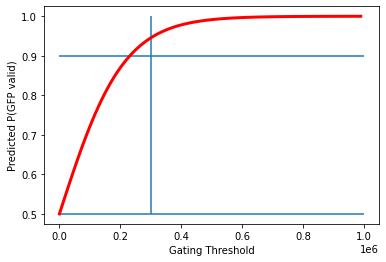

In [59]:
xs = np.arange(0, 1000000, 10000)
#plt.model()
loss = scipy.special.expit(xs * model.coef_ + model.intercept_).ravel()
plt.plot(xs, loss, color='red', linewidth=3)
plt.xlabel('Gating Threshold')
plt.ylabel('Predicted P(GFP valid)')
plt.hlines(0.5, 0, 1000000)
plt.vlines(300000, 0.5, 1.0)
plt.hlines(0.9, 0, 1000000);

# Gating from discussions with Rob Moseley

In [60]:
df.loc[:, 'log_GFP'] = np.log10(np.maximum(df['BL1_A'], 1))

First, remove what look like mis-calibrated fluorescence (BL1_A) readings:

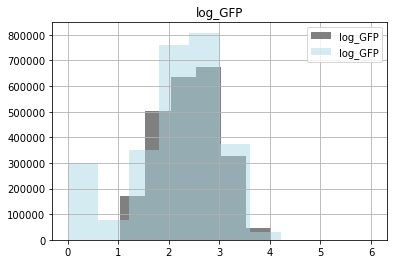

In [61]:
df_gate1 = df[df['BL1_A'] > 10]
ax = df_gate1.hist(column='log_GFP', color='gray', legend=True)
df.hist(column='log_GFP', color='lightBlue', alpha=0.5, legend=True, ax=ax);

In [62]:
from IPython.display import Markdown as md
from IPython.display import display

proportion_retained = 100 * df_gate1.shape[0]/df.shape[0]
display(md(f"This filter retains {proportion_retained:.0f}% of the events."))


This filter retains 87% of the events.

After this gating, what is the residual effect of gating by forward scatter area (FSC_A)?

Score on training data is 0.74
Score on test data is 0.74


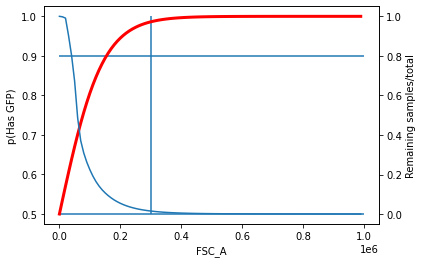

In [63]:
def local_scope(df):
    unfiltered_count = df.shape[0]
    X_train, X_test, Y_train, Y_test = train_test_split(df['FSC_A'].to_numpy(), df['GFP'].to_numpy(), test_size=0.7, random_state=0)
    model = LogisticRegression()
    model.fit(X_train.reshape((-1, 1)), Y_train)
    xs = np.arange(0, 1000000, 10000)
    loss = scipy.special.expit(xs * model.coef_ + model.intercept_).ravel()
    plt.plot(xs, loss, color='red', linewidth=3)
    plt.hlines(0.5, 0, 1000000)
    plt.vlines(300000, 0.5, 1.0)
    plt.hlines(0.9, 0, 1000000)
    ax = plt.gca()
    ax.set_xlabel('FSC_A')
    ax.set_ylabel('p(Has GFP)')
    def remainder(threshold):
        return (df['FSC_A'] > threshold).value_counts()[True] / unfiltered_count
    ax = ax.twinx()
    ax.plot(xs, np.vectorize(remainder)(xs))
    ax.set_ylabel('Remaining samples/total')
    print(f"Score on training data is {model.score(X_train.reshape((-1, 1)), Y_train):.2f}")
    print(f"Score on test data is {model.score(X_test.reshape((-1, 1)), Y_test):.2f}")
    
local_scope(df_gate1)


Score on training data is 0.74
Score on test data is 0.74


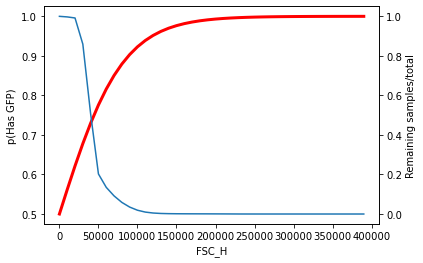

In [64]:
def local_scope(df, channel: str, max=1000000):
    unfiltered_count = df.shape[0]
    X_train, X_test, Y_train, Y_test = train_test_split(df[channel].to_numpy(), df['GFP'].to_numpy(), test_size=0.7, random_state=0)
    model = LogisticRegression()
    model.fit(X_train.reshape((-1, 1)), Y_train)
    xs = np.arange(0, max, 10000)
    loss = scipy.special.expit(xs * model.coef_ + model.intercept_).ravel()
    plt.plot(xs, loss, color='red', linewidth=3)
    #plt.hlines(0.5, 0, max)
    #plt.vlines(300000, 0.5, 1.0)
    #plt.hlines(0.9, 0, 1000000)
    ax = plt.gca()
    ax.set_xlabel(channel)
    ax.set_ylabel('p(Has GFP)')
    def remainder(threshold):
        try:
            return (df[channel] > threshold).value_counts()[True] / unfiltered_count
        except KeyError:
            return 0
    ax = ax.twinx()
    ax.plot(xs, np.vectorize(remainder)(xs))
    ax.set_ylabel('Remaining samples/total')
    print(f"Score on training data is {model.score(X_train.reshape((-1, 1)), Y_train):.2f}")
    print(f"Score on test data is {model.score(X_test.reshape((-1, 1)), Y_test):.2f}")
    
local_scope(df_gate1, 'FSC_H', max=400000)


Score on training data is 0.74
Score on test data is 0.74


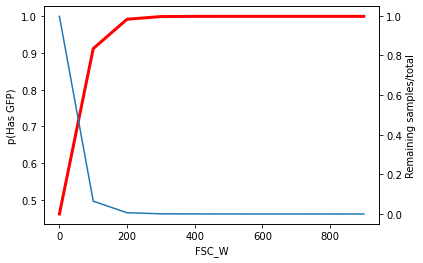

In [65]:
def local_scope(df, channel: str, max=1000000, step=10000):
    unfiltered_count = df.shape[0]
    X_train, X_test, Y_train, Y_test = train_test_split(df[channel].to_numpy(), df['GFP'].to_numpy(), test_size=0.7, random_state=0)
    model = LogisticRegression()
    model.fit(X_train.reshape((-1, 1)), Y_train)
    xs = np.arange(0, max, step)
    loss = scipy.special.expit(xs * model.coef_ + model.intercept_).ravel()
    plt.plot(xs, loss, color='red', linewidth=3)
    #plt.hlines(0.5, 0, max)
    #plt.vlines(300000, 0.5, 1.0)
    #plt.hlines(0.9, 0, 1000000)
    ax = plt.gca()
    ax.set_xlabel(channel)
    ax.set_ylabel('p(Has GFP)')
    def remainder(threshold):
        try:
            return (df[channel] > threshold).value_counts()[True] / unfiltered_count
        except KeyError:
            return 0
    ax = ax.twinx()
    ax.plot(xs, np.vectorize(remainder)(xs))
    ax.set_ylabel('Remaining samples/total')
    print(f"Score on training data is {model.score(X_train.reshape((-1, 1)), Y_train):.2f}")
    print(f"Score on test data is {model.score(X_test.reshape((-1, 1)), Y_test):.2f}")
    
local_scope(df_gate1, 'FSC_W', max=1000, step=100)

None of the above graphs suggests that it will be possible to gate by forward scatter without losing an unacceptable amount of data.